# Analyse de transgène par Nanopore

## Préparation des données (à réaliser en local ou sur serveur)

Lors du séquençage, le système Nanopore ne peut générer des fichiers avec plus de 1000 lignes. Plusieurs fastq sont ainsi produits lors d'un même run. Avant de débuter l'analyse, il faut donc concatener les fastq.

In [ ]:
cat *.fastq > final.fastq

La connexion au serveur de l'IFB a été simplifié et sécurisé grâce à l'utilisation d'une clef SSH préalablement configuré dans le DU

In [ ]:
ssh LOGIN@core.cluster.france-bioinformatique.fr

Utilisation du chemin absolu pour se placer dans le dossier du script et des données

In [4]:
cd /shared/projects/form_2021_29/mchicard/Nanopore



Vérification de la localisation

In [6]:
pwd

/shared/projects/form_2021_29/mchicard/Nanopore


Les données peuvent être transférér sur le serveur avec le Jupyter de l'IFB :
https://jupyterhub.cluster.france-bioinformatique.fr

## Calcul sur les serveurs de l'IFB

Une fois les données transférées, il faut vérifier leurs intégritées

In [ ]:
srun -A form_2021_29 raw/md5sum -c reads_md5sum.txt

L'outil minimap pour l'alignement demande une minimum de mémoire vive pour fonctionner, il faut donc allouer une puissance de calcul suffisante sur le serveur

In [ ]:
salloc --cpus-per-task=12 --mem=32G

Il faut ensuite vérifier si l'outil est bien présent

In [ ]:
module avail -l minimap2

L'outil peut ensuite être chargé (ici dans sa dernière version)

In [ ]:
module load minimap2/2.18

L'outil minimap2 peut être utilisé, il faut lui renseigner la séquence de référence et le fastq. Le fichier de sortie sera un .sam et il faut également ajouter l'option -ax map-ont pour un alignement à partir de fichier Nanopore.

In [ ]:
srun minimap2 pRMCE_CD4_CTG.fasta R-19-153-5.fastq > R-19-153-5.sam -ax map-ont

Il faut maintenant transformer le .sam en .bam pour réduire sa taille et donc le manipuler plus facilement. L'outil samtools sera utilisé pour la transformation, le tri et l'indexage.

In [ ]:
module avail -l samtools

In [ ]:
module load samtools/1.15.1

In [ ]:
srun samtools view -bS R-19-153-5.sam > R-19-153-5.bam

In [ ]:
srun samtools index R-19-153-5.bam > R-19-153-5.sorted.bam

Pour controler la couverture de chaque région, l'outil bedtools va être utilisé. Cet outil permet de calculer la couverture de chaque région d'un fichier .bed mais l'option -ibam va permettre de se passer d'un fichier .bed et de découper le génome de référence en région de couverture similaire. L'option -ibam permet de renseigner un fichier .bam et l'option -bg le découpage "automatique".

In [ ]:
module avail -l bedtools

In [ ]:
module load bedtools/2.30.0

In [ ]:
srun bedtools genomecov -ibam R-19-153-5.sorted.bam -bg > R-19-153-5.bedgraph

Plusieurs fastq doivent subir le même traitement. Un script bash de Pierre Poulain a donc été modifié pour automatiser ces étapes.

In [ ]:
sbatch -A form_2021_29 script_mc.sh

Un numéro de JOB est donné lors du lancement du script et permet de suivre le déroulé des étapes grâce à la commande suivante

In [2]:
sacct --format=JobID,JobName,State,Start,Elapsed,CPUTime,NodeList -j 23369129

       JobID    JobName      State               Start    Elapsed    CPUTime        NodeList 
------------ ---------- ---------- ------------------- ---------- ---------- --------------- 
23369129_0   script_mc+    RUNNING 2022-06-17T11:22:20   00:06:20   00:50:40     cpu-node-82 
23369129_0.+      batch    RUNNING 2022-06-17T11:22:20   00:06:20   00:50:40     cpu-node-82 
23369129_0.0   minimap2    RUNNING 2022-06-17T11:22:23   00:06:17   00:50:16     cpu-node-82 
23369129_1   script_mc+    RUNNING 2022-06-17T11:22:20   00:06:20   00:50:40     cpu-node-74 
23369129_1.+      batch    RUNNING 2022-06-17T11:22:20   00:06:20   00:50:40     cpu-node-74 
23369129_1.0   minimap2    RUNNING 2022-06-17T11:22:22   00:06:18   00:50:24     cpu-node-74 
23369129_2   script_mc+    RUNNING 2022-06-17T11:22:20   00:06:20   00:50:40     cpu-node-75 
23369129_2.+      batch    RUNNING 2022-06-17T11:22:20   00:06:20   00:50:40     cpu-node-75 
23369129_2.0   minimap2    RUNNING 2022-06-17T11:22:21   00:

<br>Le JOB peut être annulé avec la commande suivante

In [ ]:
scancel JOBID

Les données peuvent ensuite être transféré en local après s'être placé dans le dossier de copie (ou en utilisaant Jupyter)

In [ ]:
scp mchicard@core.cluster.france-bioinformatique.fr:/shared/ifbstor1/projects/form_2021_29/mchicard/Nanopore/coverage/*.bedgraph

Des calculs préliminaires sur R peuvent également réaliser dans le server et il faut se placer dans le dossier de sortie des résultats bedtools

In [2]:
cd coverage

In [3]:
pwd

/shared/ifbstor1/projects/form_2021_29/mchicard/Nanopore/coverage


## Vérification des données sur R

Pour vérifier les données, le noyau de Jupyter peut être modifier pour passer en <b>R</b>

In [8]:
coverage <- read.table("coverage-barcode01.bedgraph", sep = "\t")

In [9]:
colnames(coverage)<-c("vector","start","end","cov")

In [10]:
head(coverage)

,vector,start,end,cov
,<chr>,<int>,<int>,<dbl>
1,pRMCE_CD4_CTG,2486,2499,6
2,pRMCE_CD4_CTG,2499,2500,1
3,pRMCE_CD4_CTG,2500,2522,6
4,pRMCE_CD4_CTG,2522,2523,5
5,pRMCE_CD4_CTG,2523,2541,6
6,pRMCE_CD4_CTG,2541,2546,2


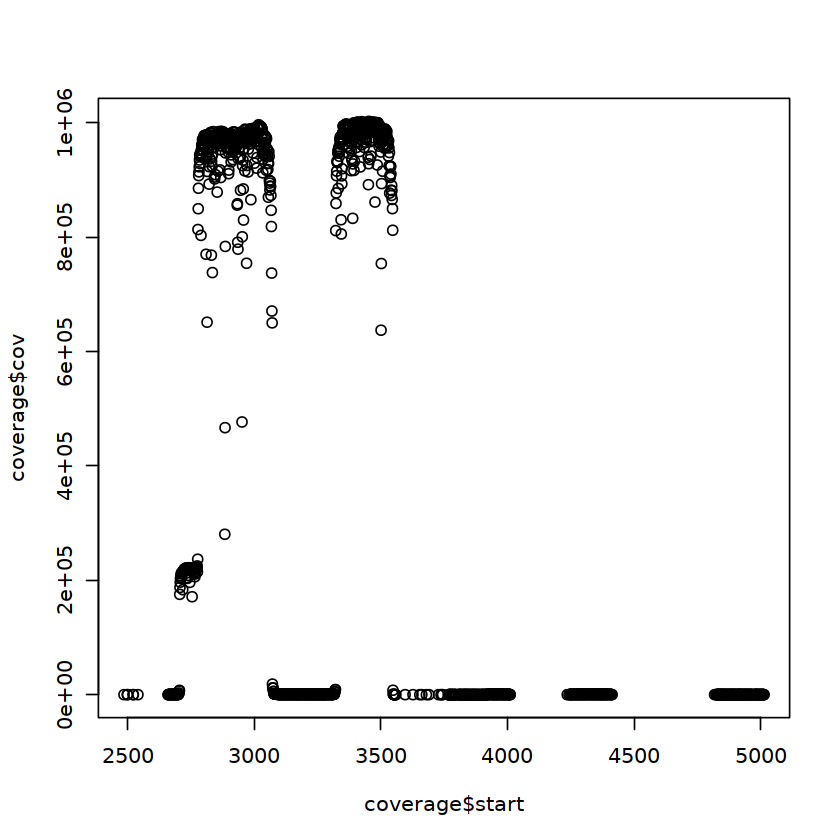

In [12]:
plot(coverage$start,coverage$cov)